<h1> Segmenting and Clustering Neighborhoods in Toronto

Import necessary libraries and read the Table from Wikipedia into a new dataframe

In [1]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print("Folium installed and imported")

Folium installed and imported


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

df_html = pd.read_html(url)
df = df_html[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Check, if there are boroughs that have the value "not assigned" and drop these rows

In [4]:
df_bor = df[df.Borough != "Not assigned"].reset_index(drop = True)
df_bor.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Check the Neigbourhood, if there is any Neighbourhodd that is not assigned and replace it with the assigned borough. The "replaced counter" is only to double check the number of replaced neighborhoods.

In [5]:
replaced = 0

for i in range(len(df_bor)):
    if df_bor["Borough"][i] != "Not assigned" and df_bor["Neighbourhood"][i] == "Not assigned":
        df_bor["Neighbourhood"][i].replace("Not assigned", df_bor["Borough"][i], inplace = True)
        replaced += 1
        
print(str(replaced))


0


Check, if more than one neighbourhood exists in one postal code area and group it

In [6]:
df_bor_grouped = df_bor.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df_bor_grouped.reset_index(inplace=True)

Look at the shape of the cleaned dataset

In [7]:
df_bor_grouped.shape

(103, 3)

Import geospatial data from website

In [8]:
!wget -O Geospatial_Coordinates.csv http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv

--2020-08-02 13:06:24--  http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv
Resolving cocl.us (cocl.us)... 169.48.113.194, 158.85.108.86, 158.85.108.83
Connecting to cocl.us (cocl.us)|169.48.113.194|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv [following]
--2020-08-02 13:06:26--  https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv
Connecting to cocl.us (cocl.us)|169.48.113.194|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-08-02 13:06:27--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 185.235.236.197
Connecting to ibm.box.com (ibm.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2

Create a new Dataframe from csv

In [9]:
df_geo = pd.read_csv("Geospatial_Coordinates.csv")
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the two datasets and append the old dataset with coordinates

In [10]:
df_bor_geo = pd.merge(df_bor, df_geo, on = "Postal Code", how = "left")
df_bor_geo.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Create a new map of the city of Toronto with coordinates of M5A and insert the different neighbourhoods as popups

In [11]:
toronto = folium.Map(location=[43.654260,-79.360636],zoom_start=11) 

In [12]:
for borough,neighbourhood, latitude, longitude in zip(df_bor_geo["Borough"],df_bor_geo["Neighbourhood"], df_bor_geo["Latitude"], df_bor_geo["Longitude"]):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [latitude,longitude],
    radius=5,
    popup=label,
    color="green",
    fill=True,
    fill_color="#3186cc",
    fill_opacity=0.7,
    parse_html=False).add_to(toronto)
    
toronto

This is the image created by the code above and shows the city of Toronto with all neighbourhoods

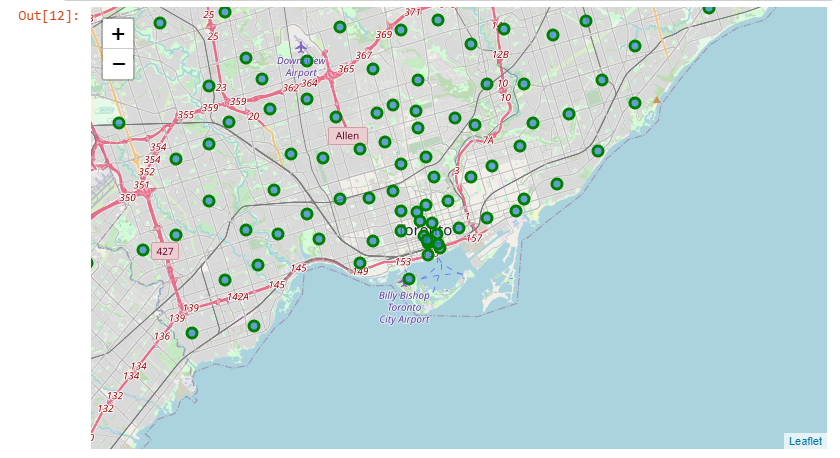

Set up the cluster dataframe only with latitude and longitude values

In [13]:
toronto_clusters = df_bor_geo.drop(["Postal Code","Borough","Neighbourhood"],1)
toronto_clusters.head()

,Latitude,Longitude
0,43.753259,-79.329656
1,43.725882,-79.315572
2,43.654260,-79.360636
3,43.718518,-79.464763
4,43.662301,-79.389494


Use the number of boroughs for number of clusters (k)

In [14]:
len(df_bor_geo["Borough"].value_counts())

10

Set up a KMeans clustering algorithm with the number of boroughs as k and append the dataframe with the cluster labels

In [15]:
k=10

kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clusters)
kmeans.labels_
df_bor_geo.insert(0, 'Cluster Labels', kmeans.labels_)

In [16]:
df_bor_geo.head()

,Cluster Labels,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,4,M3A,North York,Parkwoods,43.753259,-79.329656
1,8,M4A,North York,Victoria Village,43.725882,-79.315572
2,1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Create a new map with the cluster labels

In [17]:
# create map
toronto_borough_clusters = folium.Map(location=[43.654260,-79.360636],zoom_start=11) 

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for cluster, neighbourhood, latitude, longitude in zip(df_bor_geo["Cluster Labels"],df_bor_geo["Neighbourhood"], df_bor_geo["Latitude"], df_bor_geo["Longitude"]):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_borough_clusters)
       
toronto_borough_clusters

This is the image created by the code above and shows the nieghbourhoods clustered to the boroughs by KMeans

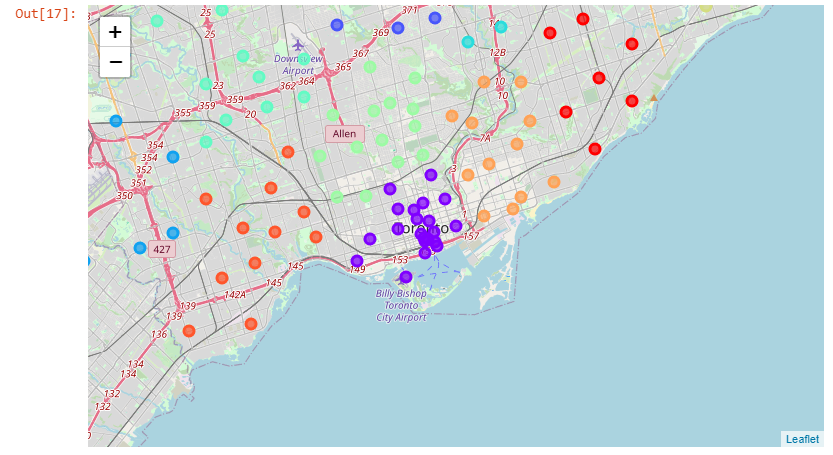